# Quick scripting for XPS-tool

## Nanolab data (Al K-alpha radiation 1486.61 eV)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Embedded imports
import os, sys
import matplotlib.pyplot as plt

In [3]:
# Third party imports
import numpy as np
import pandas as pd

In [4]:
# Temporary solution for local imports
sys.path.append('..')
import xpstool.helpers as xpsmodule

In [5]:
# Constants
al_k_alpha = 1486.61 # Al K-alpha photon source energy

In [6]:
# Full path to data files
data_path = "/Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Rh80Fe20_XPS/XY_RhFe/"
# Folders to add to the full path above 
data_folders = [
    "Rh80Fe20(111)",
    "Rh80Fe20(111)_7_11",
    "Rh80Fe20(111)_8_11",
    "Rh80Fe20(111)_9_11"
]

# List of all directories (combine the full path with specified folders)
all_dirs = ["".join([data_path, data_folder]) for data_folder in data_folders]

In [11]:
# Iterating through directories displaying existing files
all_files = []
for i, dirname in enumerate(sorted(all_dirs)):
    if i > 0: # Just to make it prettier (no empty line before the first output)
        print() # Otherwise, add an empty line to separate outputs
    print(f"all_dirs[{i}]: {dirname}")
    
    # Iterating through the list of files inside the directory. Files are sorted
    # according to the last _number value in their name using lambda function
    files = []
    for j, filename in enumerate(sorted(os.listdir(all_dirs[i]), 
                                 key=lambda x:int(x.rpartition('.')[0].rpartition('_')[2]))):
        files.append(filename)
        print(f"---> all_files[{i}][{j}]: {filename}")
    all_files.append(files)

all_dirs[0]: /Users/Shipilin/Documents/07_DataAnalysis/2018-RhFe_alloys/2018-November_Rh80Fe20/2018-11_Rh80Fe20_XPS/XY_RhFe/Rh80Fe20(111)
---> all_files[0][0]: Rh80Fe20(111)_1.xy
---> all_files[0][1]: Rh80Fe20(111)_2.xy
---> all_files[0][2]: Rh80Fe20(111)_3.xy
---> all_files[0][3]: Rh80Fe20(111)_4.xy
---> all_files[0][4]: Rh80Fe20(111)_5.xy
---> all_files[0][5]: Rh80Fe20(111)_6.xy
---> all_files[0][6]: Rh80Fe20(111)_7.xy
---> all_files[0][7]: Rh80Fe20(111)_8.xy
---> all_files[0][8]: Rh80Fe20(111)_9.xy
---> all_files[0][9]: Rh80Fe20(111)_10.xy
---> all_files[0][10]: Rh80Fe20(111)_11.xy
---> all_files[0][11]: Rh80Fe20(111)_12.xy
---> all_files[0][12]: Rh80Fe20(111)_13.xy
---> all_files[0][13]: Rh80Fe20(111)_14.xy
---> all_files[0][14]: Rh80Fe20(111)_15.xy
---> all_files[0][15]: Rh80Fe20(111)_16.xy
---> all_files[0][16]: Rh80Fe20(111)_17.xy
---> all_files[0][17]: Rh80Fe20(111)_18.xy
---> all_files[0][18]: Rh80Fe20(111)_19.xy
---> all_files[0][19]: Rh80Fe20(111)_20.xy
---> all_files[0][20]

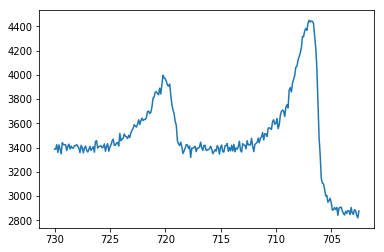

In [16]:
# Plot preview of a SPEC.xy file
with open("/".join([all_dirs[2], all_files[2][30]])) as f:
    lines = f.read().splitlines()

energy, counts = [], []
info_lines = []
for line in lines:
    if not line.strip():
        continue # Scip empty lines
    elif line.strip().startswith('#'):
        info_lines.append(line) # Save info lines
    else:
        xy = line.split()
        x = float(xy[0].strip())
        y = float(xy[1].strip())
        if y > 0:
            energy.append(x)
            counts.append(y)

# If the energy values in the file were on the kinetic scale,
# Transform them to binding scale
binding_energy = [exitation_energy - value for value in energy]

scan = xpsmodule.Scan(binding_energy, counts, info=xpsmodule.parseSpecFileInfo(info_lines))

#%matplotlib qt # Plotting in a separate interactive window
plt.plot(scan.Data["energy"], scan.Data["counts"])
plt.gca().invert_xaxis()